#### Fashion MNIST-ITBA-LAB ML

URL: https://www.kaggle.com/c/fashion-mnist-itba-lab-ml

In [1]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras import regularizers
import os

np.set_printoptions(threshold=np.inf)#Imprimir numpy array/matriz completa

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class PlotLosses(keras.callbacks.Callback):
    def __init__(self, plot_interval=1, evaluate_interval=10, x_val=None, y_val_categorical=None):
        self.plot_interval = plot_interval
        self.evaluate_interval = evaluate_interval
        self.x_val = x_val
        self.y_val_categorical = y_val_categorical
        #self.model = model
    
    def on_train_begin(self, logs={}):
        print('Begin training')
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        if self.evaluate_interval is None:
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.acc.append(logs.get('acc'))
            self.val_acc.append(logs.get('val_acc'))
            self.i += 1
        
        if (epoch%self.plot_interval==0):
            clear_output(wait=True)
            f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,5))
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="val_loss")
            ax1.legend()

            ax2.plot(self.x, self.acc, label="acc")
            ax2.plot(self.x, self.val_acc, label="val_acc")
            ax2.legend()
            plt.show();
        #score = self.model.evaluate(x_test, y_test_categorical, verbose=0)
        
        #print("accuracy: ", score[1])
    
    def on_batch_end(self, batch, logs={}):
        if self.evaluate_interval is not None:
            if (batch%self.evaluate_interval==0):
                self.i += 1
                self.logs.append(logs)
                self.x.append(self.i)
                self.losses.append(logs.get('loss'))
                self.acc.append(logs.get('acc'))

                if self.x_val is not None:
                    score = self.model.evaluate(self.x_val, self.y_val_categorical, verbose=0)
                    self.val_losses.append(score[0])
                    self.val_acc.append(score[1])

##### Descargo y guardo archivos

In [4]:
from urllib.request import urlretrieve

if not os.path.exists("train_images.npy"):
    urlretrieve("https://drive.google.com/uc?authuser=0&id=1q58X5sykNV3u7f9WDlDsFERGdDugzcjT&export=download", "train_images.npy")
    
if not os.path.exists("train_labels.npy"):
    urlretrieve("https://drive.google.com/uc?authuser=0&id=1J53yQWSS3V7MAA2-yB4k062k9eYvDRvC&export=download", "train_labels.csv")

if not os.path.exists("test_images.npy"):
    urlretrieve("https://drive.google.com/uc?authuser=0&id=1VJ7ghtlBPGfuLezev7xv5vFyfb0Zklik&export=download", "test_images.npy")


In [5]:
x = np.load('./train_images.npy')
y = np.loadtxt('./train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load('./test_images.npy')

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

In [18]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

--------
##### Entreno el modelo

In [19]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_valid, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True)

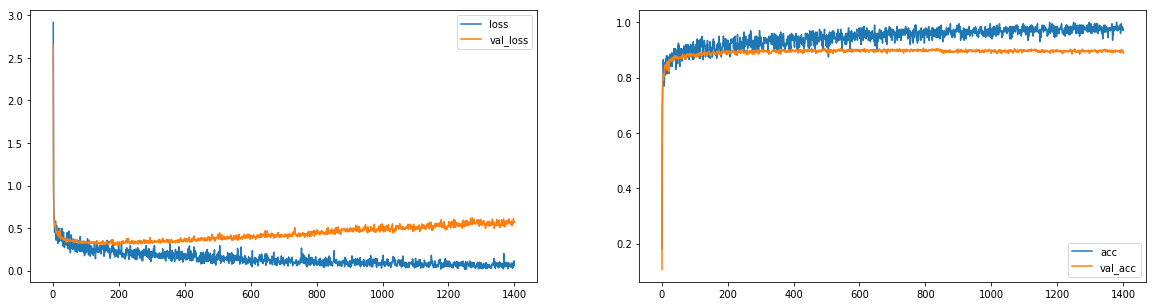


Epoch 00100: val_loss did not improve


In [20]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(100, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(60, activation='relu', kernel_initializer='normal', name='middle3'))
model.add(Dense(30, activation='relu', kernel_initializer='normal', name='middle4'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

# Compilo el modelo
lr = 0.001 #0.01, 0.001, 0.00001, 0.000001, 0.00000001
batch_size = 200
epochs = 100

optimizer = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
#optimizer = optimizers.adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(x_train, 
                       y_train_categorical,
                       epochs=epochs, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [21]:
loss, acc = model.evaluate(x_valid, y_val_categorical)
print("loss:", loss)
print("Accuracy:", acc)

6000/6000 [==============================] - 0s 41us/step
loss: 0.5593717594246069
Accuracy: 0.8895


---
##### Guardo resultados en archivo 

In [22]:
test_prediction = model.predict(x_test)
test_labels = np.argmax(test_prediction, axis = 1)
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission.csv", sep=',',index=True,  index_label='Id')